In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import umap

import matplotlib.pyplot as plt
import matplotlib
 
import pickle as pk

# Load data

In [2]:
file_name = 'dentate-gyrus-neurogenesis_hochgerner'

with open('data/'+file_name+'.pkl', 'rb') as f:
    [x, grouping, gene_names, milestone_net] = pk.load(f)

# For non-UMI
# x = x.astype(np.float32).toarray()
# scale_factor = np.sum(x,axis=1, keepdims=True)/1e4
# x = x/scale_factor    

# Preprocess data

min normailized value: 0.0
max normailized value: 8.6256895


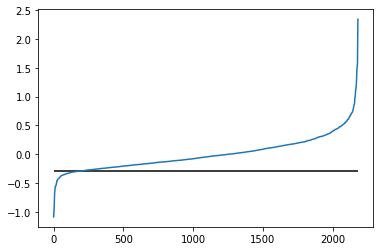

Number of cells in each class: 
1 <---> Granule-mature      1532
0 <---> Granule-immature    1127
3 <---> Neuroblast 2         747
2 <---> Neuroblast 1          94
4 <---> nIPC                  85
dtype: int64


In [3]:
from scTGMVAE import scTGMVAE
tf.keras.backend.clear_session()
model = scTGMVAE()
model.get_data(x, grouping, gene_names=gene_names)
model.preprocess_data(gene_num=2000)

# Build model

In [4]:
model.build_model(data_type = 'UMI', dim_latent = 8, dimensions=[16], save_weights=True)

Below is the process to train the momdel. You can skip these steps to section **Inference**.

# Pretrain

In [ ]:
model.pre_train(L=1, batch_size=32, early_stopping_tolerance=1)

# Clustering and initialize model

In [5]:
# load pretrained weight
model.load_model('weight/dentate/pre_train.checkpoint')

Here we provide a few functions that can be easily used to do Louvain clustering.

In [ ]:
from scTGMVAE import get_igraph, louvain_igraph, plot_clusters
z = model.get_latent_z()
embed_z = umap.UMAP().fit_transform(z)
g = get_igraph(z)

You can choose different resolution parameter to get satisfied clustering results.

[0 1 2 3 4 5 6 7 8]


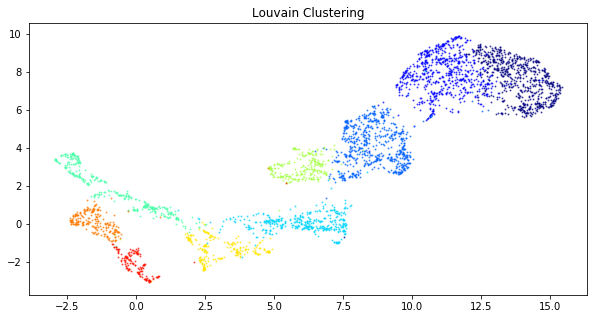

In [7]:
labels = louvain_igraph(g, 0.6)
plot_clusters(embed_z, labels)
print(np.unique(labels))

[0 1 2 3 4]


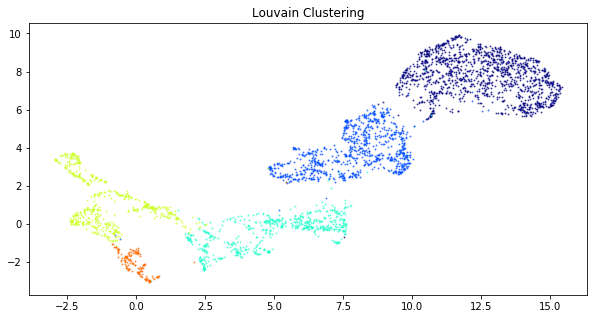

In [8]:
labels = louvain_igraph(g, 0.3)
plot_clusters(embed_z, labels)
print(np.unique(labels))

Then initialze the model by clustering results.

In [9]:
NUM_CLUSTER = len(np.unique(labels))
n_states = int((NUM_CLUSTER+1)*NUM_CLUSTER/2)
cluster_center = [int((NUM_CLUSTER+(1-i)/2)*i) for i in range(NUM_CLUSTER)]
mu = np.zeros((z.shape[1],NUM_CLUSTER))
pi = np.ones((1,n_states)) * 0
for i in np.arange(NUM_CLUSTER):
    mu[:,i] = np.mean(z[labels==i], axis=0)
    pi[0, cluster_center[i]] = np.mean(labels==i)
    
model.init_GMM(NUM_CLUSTER,           # numebr of clusters
               cluster_labels=labels, # (optional) clustering labels for plotting
               mu=mu,                 # (optional) initial mean
               pi=pi)                 # (optional) initial pi

# Train

In [ ]:
model.train(batch_size=32, L=1, weight=[1,1,1],
            learning_rate=1e-4, early_stopping_tolerance=0.01, plot_every_num_epoch=15)

# Inference

In [5]:
# load model weight
model.load_model('weight/dentate/train.checkpoint',
                 n_clusters=5 # parameter to initialize or re-initialize the GMM layer
                )
# initialze inference
model.init_inference(L=100) # L is the number of MC samples
# after initialization, we can access some variables by model.pc_x, model.w, model.w_tilde, etc..

In [6]:
import networkx as nx
# compute inference score, and get umap embedding
# a plot of clustering result will be displayed
G = model.comp_inference_score(method='mean',  # posterior mean of c
                               thres=0.5,      # threshold for compute the conditional probablity
                               no_loop=True)   # if no_loop=True, then find the maximum spanning tree
# returned G is the score graph
print(np.round(nx.to_numpy_matrix(G), 2))
print(G.edges)

No clustering labels available!
[[0.   0.34 0.   0.   0.  ]
 [0.34 0.   0.35 0.   0.  ]
 [0.   0.35 0.   0.   0.44]
 [0.   0.   0.   0.   0.36]
 [0.   0.   0.44 0.36 0.  ]]
[(0, 1), (1, 2), (2, 4), (3, 4)]


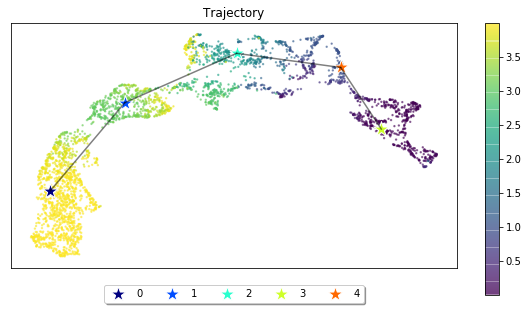

In [7]:
model.plot_trajectory(init_node=3,  # initial node for computing pseudotime
                      cutoff=None)  # cutoff score for edges, if cutoff=None then find the maximum spanning tree

In [8]:
model.gene_names

array(['Hmgb2', 'Fabp7', 'Tuba1a', ..., 'Pex11b', 'Tmem261', 'Rap1gap'],
      dtype='<U13')

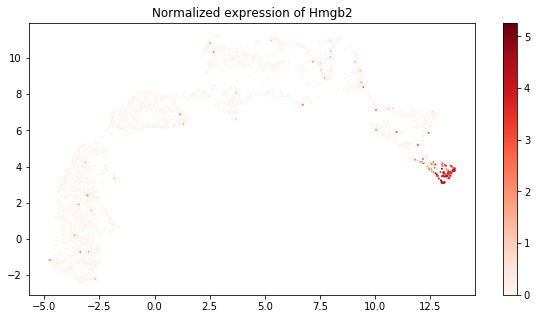

In [13]:
model.plot_marker_gene('Hmgb2')

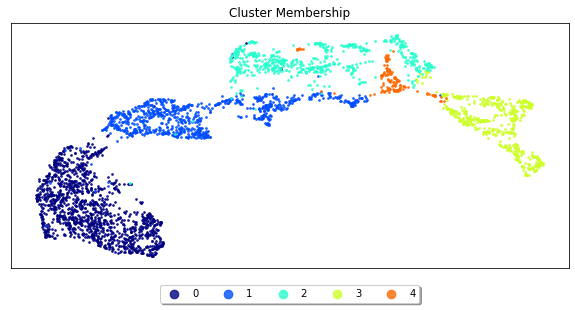

[[0.   0.28 0.   0.   0.  ]
 [0.28 0.   0.3  0.   0.  ]
 [0.   0.3  0.   0.   0.36]
 [0.   0.   0.   0.   0.3 ]
 [0.   0.   0.36 0.3  0.  ]]
[(0, 1), (1, 2), (2, 4), (3, 4)]


In [13]:
G = model.comp_inference_score(method='map',  
                               thres=0.5,     
                               no_loop=True)  
# returned G is the score graph
print(np.round(nx.to_numpy_matrix(G), 2))
print(G.edges)

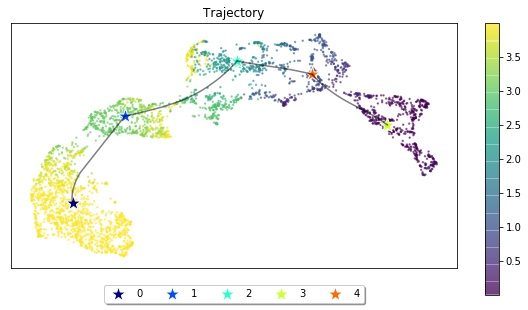

In [14]:
model.plot_trajectory(init_node=3, 
                      cutoff=None) 